In [1]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
PROCESSED_DATA = os.path.join(ROOT_DIR, 'data/processed')
txt = os.path.join(ROOT_DIR, 'data/processed/keep_img_ids.txt')
sys.path.append(ROOT_DIR)  # To find local version of the library

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import skimage.transform as st
import skimage
import random
import cv2 as cv

from models.maskrcnn.mrcnn import visualize,utils
import helper as hp

IMG_DIR = os.path.join(PROCESSED_DATA, 'images')
LBL_DIR = os.path.join(PROCESSED_DATA, 'segmentations')
MAP_DIR = os.path.join(PROCESSED_DATA, 'disparity_maps')


keeplabels ={'sidewalk':8,
            'rail track':10,
            'wall':12,
            'fence':13,
            'guard rail':14,
            'pole':17,
            'polegroup':18,
            'vegetation': 21,
            'car':26,
            'bicycle':33}
inv_keeplabels =  {
    8: 'sidewalk',
    10: 'rail track',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    17: 'pole',
    18:  'polegroup',
    21: 'vegetation',
    26: 'car',
    33: 'bicycle'}

# Labeling IOUs

Ignroe this mor now
```for all 3277 pics
for all class, generate each instances of mask
    taken care of with the polygon json processing
for each mask, label them 
    id_class_instance-num e.g.
        aachen_000003_000019_sidewalk_001
        aachen_000003_000019_car_001
        ...
    if there are 10 labels: 3 of them sidewalk and 7 of them not sidewalk
        the data for the classifer will be something like
          img-id_sidewalk_instance-id   |   img-id_class_instance-id   |   IOU (not read but calculated)    |  label
```


In [2]:
df = pd.read_csv(os.path.join(PROCESSED_DATA,'labels_obs.csv'),index_col=None)
df.head()
data = df.set_index('ID').T.to_dict('list')

all_labels = []
all_obs = []
for key, val in data.items():
    labs,obs = val
    labs= np.array([int(i) for i in labs.split(' ')[:-1]])
    obs = np.array([int(i) for i in obs.split(' ')[:-1]])
    data[key] = (labs, obs)


    all_labels.append(labs)
    all_obs.append(obs)
    

## reading sample data
## not too bad of a running time, it takes rougly 3mins to 
## go through all 3277 images
## txt = os.path.join(ROOT_DIR, 'data/processed/keep_img_ids.txt')

# sample 100 images
# txt = os.path.join(ROOT_DIR, 'data/processed/sample.txt')
# with open(txt) as f:
#     sample_ids= f.readlines()

# # all the image ids
# sample_ids = [i.strip('\n').split('.')[0] for i in sample_ids]

# # all instance labels for each id
# sample_labels = [data[id] for id in sample_ids]

# # {img_id: all_instance_mask}
# data_mask = {}

# for id in sample_ids[:3]:
#     path_to_mask = os.path.join(LBL_DIR, f'{id}.json')
#     label = data[id][0]
#     masks = hp.create_mask(path_to_mask,label,(256,512))
#     data_mask[id] = masks
#     # np.save(os.path.join(PROCESSED_DATA,'masks',f'{id}.npy'),masks)
    # data[k] = np.array([int(i) for i in data[k]])

In [3]:
labels_dict = {
    8: (1,'sidewalk'),
    10: (2,'rail track'),
    12: (3,'wall'),
    13: (4,'fence'),
    14: (5,'guard rail'),
    17: (6,'pole'),
    18:  (7,'polegroup'),
    21: (8,'vegetation'),
    26: (9,'car'),
    33: (10,'bicycle')}

a_labs = []
a_obs = []
for ls in all_labels:
    for l in ls:
        a_labs.append(labels_dict[l][0])

for ls in all_obs:
    for l in ls:
        a_obs.append(l)

a_labs = np.array(a_labs)
a_obs = np.array(a_obs)

print(len(a_labs), len(a_obs))

115567 115567


In [6]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes = np.unique(a_labs),
                                            y=a_labs)
weights

array([1.38602782e+00, 8.95868217e+01, 6.03798328e+00, 4.21162536e+00,
       2.35851020e+02, 2.27181050e-01, 3.33046110e+01, 6.92349629e-01,
       3.88499681e-01, 2.43966646e+00])

In [8]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes = np.unique(a_obs),
                                            y=a_obs)
np.unique(a_obs),weights

(array([0, 1]), array([0.69053765, 1.81207664]))

In [61]:
labs, counts = np.unique(a_obs, return_counts=True)
print(f'pos-neg ratio: {counts[1]}:{counts[0]} = {counts[1]/counts[0]}')
print(f'neg-pos ratio: {counts[0]}:{counts[1]} = {counts[0]/counts[1]}')


pos-neg ratio: 31888:83679 = 0.3810752996570227
neg-pos ratio: 83679:31888 = 2.6241532865027595


([<matplotlib.axis.XTick at 0x290c7d1f0>,
 [Text(0, 0, 'not obstruction'), Text(1, 0, 'obstruction')])

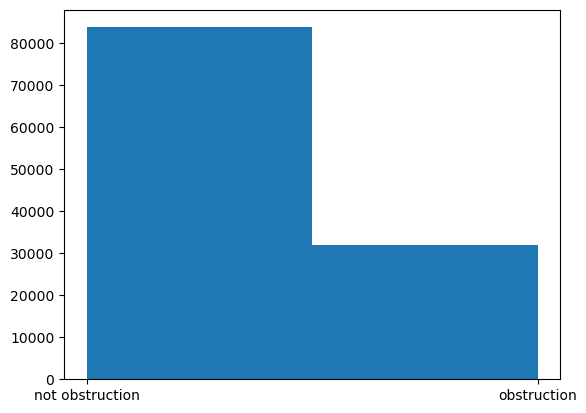

In [55]:
plt.hist(a_obs, bins = 2, range=(0,1))
plt.xticks(ticks=np.unique(a_obs),labels=['not obstruction','obstruction'])

([<matplotlib.axis.XTick at 0x2909413d0>,
 [Text(1, 0, 'sidewalk'),
  Text(2, 0, 'rail track'),
  Text(3, 0, 'wall'),
  Text(4, 0, 'fence'),
  Text(5, 0, 'guard rail'),
  Text(6, 0, 'pole'),
  Text(7, 0, 'polegroup'),
  Text(8, 0, 'vegetation'),
  Text(9, 0, 'car'),
  Text(10, 0, 'bicycle')])

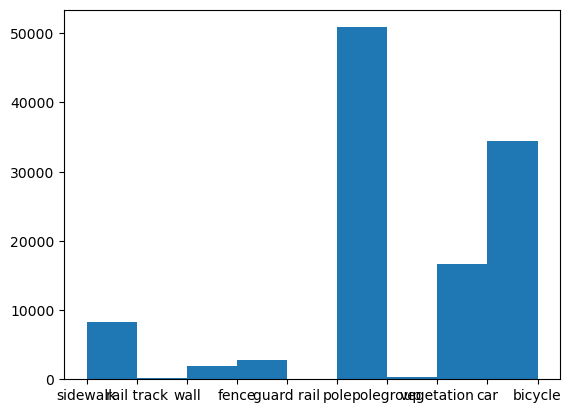

In [46]:
# x,y = np.histogram(a_labs, bins = np.unique(a_labs))
plt.hist(a_labs, bins = np.unique(a_labs))
plt.xticks(ticks=np.unique(a_labs),labels=[labels_dict[i][1] for i in labels_dict])

# Visualize sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1964


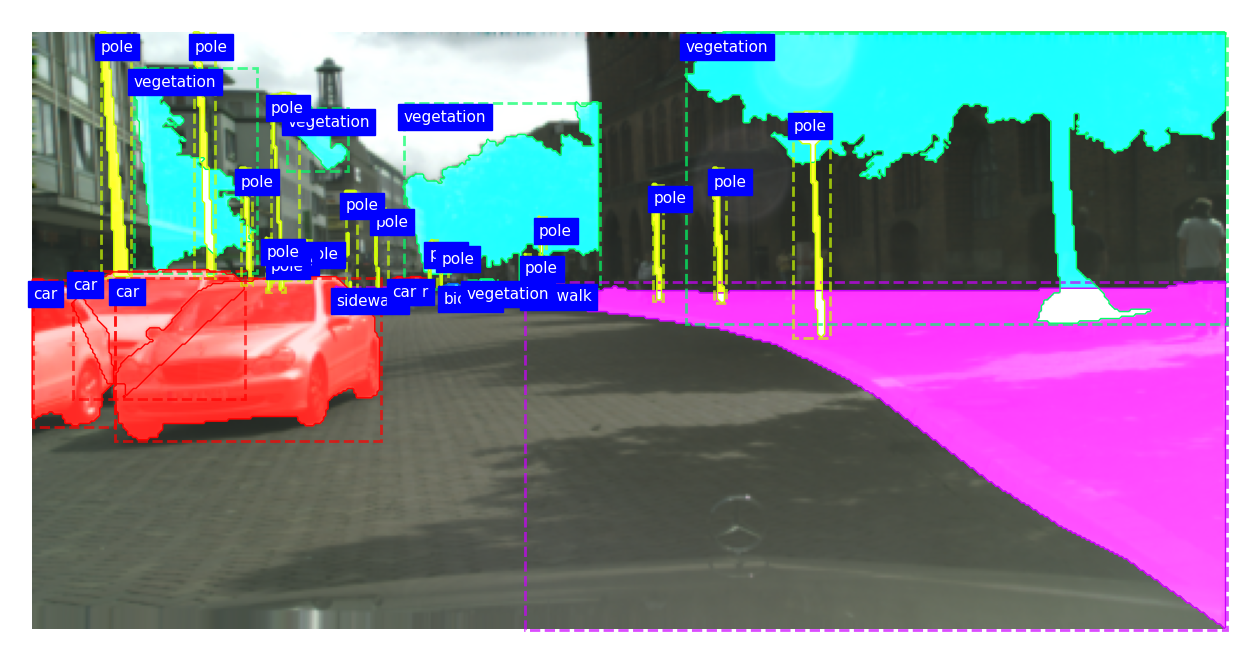

In [19]:

i = random.randint(0,len(data))
dim = (256,512)
labels_dict = {
    8: 'sidewalk',
    10: 'rail track',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    17: 'pole',
    18:  'polegroup',
    21: 'vegetation',
    26: 'car',
    33: 'bicycle'}

# i=71
# i = 32
# i=60
# i=81



id = list(data)[i]
# get the mask and label of this specific i
labels = data[id][0]
obs = data[id][1]
names = [labels_dict[y]for y in labels] #label in plain english

# creating the mask
path_to_mask = os.path.join(LBL_DIR, f'{id}.json')
mask = hp.create_mask(path_to_mask, labels, resize=(256,512) )


rgbimg = plt.imread(f'{IMG_DIR}/{id}.png')
rgbimg = st.resize(rgbimg, dim)


# # # extract all the bounding boxes 
bboxes= utils.extract_bboxes(mask)
print(i)
visualize.display_instances(rgbimg,bboxes,mask,labels,labels_dict)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


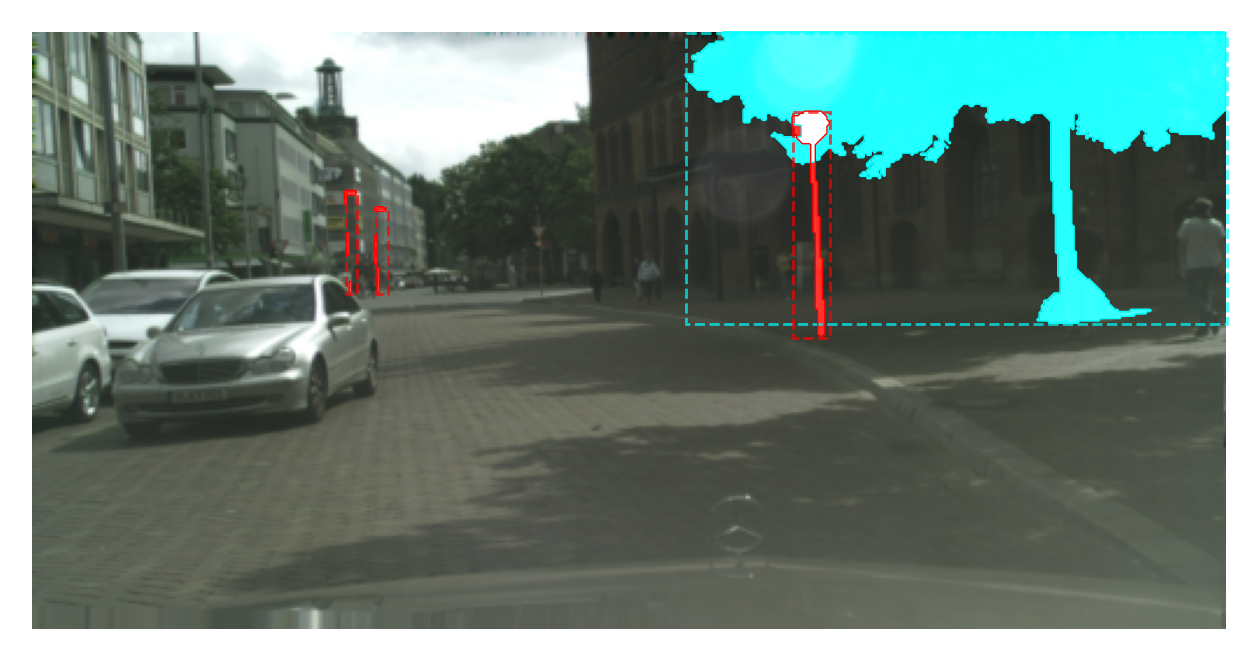

In [22]:
ious = hp.generate_ious(labels, mask) 
captions = hp.generate_captions_obstructed(labels, ious, IOU_THRESHOLD = 0.00)

visualize.display_instances(rgbimg,bboxes[obs>0],mask[:,:,obs>0],labels[obs>0],labels_dict, captions=captions)

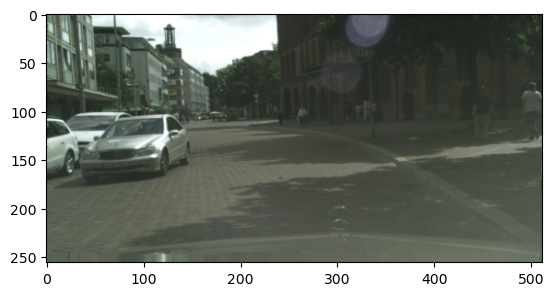

In [21]:
plt.imshow(rgbimg)